In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


# 【問題1】スクラッチを振り返る
ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙してください。  

（例）  

・重みを初期化する必要があった  
・エポックのループが必要だった  
それらがフレームワークにおいてはどのように実装されるかを今回覚えていきましょう。



## 解答
・ミニバッチ処理をする必要があった。  
・フォーワードプロパゲーション    
・活性化関数の使用  
・交差エントロピー誤差（損失関数）（損失の算出）  
・バックプロパゲーション  
・最適化処理(勾配降下法）

## データセットの用意
以前から使用しているIrisデータセットを使用します。以下のサンプルコードではIris.csvが同じ階層にある想定です。  

Iris Species  

目的変数はSpeciesですが、3種類ある中から以下の2種類のみを取り出して使用します。  

Iris-versicolor  
Iris-virginica

# 【問題2】スクラッチとTensorFlowの対応を考える
以下のサンプルコードを見て、先ほど列挙した「ディープラーニングを実装するために必要なもの」がTensorFlowではどう実装されているかを確認してください。  

それを簡単に言葉でまとめてください。単純な一対一の対応であるとは限りません。

## 解答
・ミニバッチ処理をする必要があった。=> 一緒。  
・フォーワードプロパゲーション =>　example_net関数の中で定義されている。　  
・活性化関数の使用  => tf.nn.relu関数を使用し、example_net関数の中で定義されている。  
・交差エントロピー誤差（損失関数）（損失の算出） => tf.reduce_mean関数を使用し実装している。    
・バックプロパゲーション  =>   
・最適化処理(勾配降下法）=> tf.train.AdamOptimizer()関数とoptimizer.minimize()関数を使用し定義されている。  

## 3.他のデータセットへの適用
これまで扱ってきた小さなデータセットがいくつかあります。下記サンプルコードを書き換え、これらに対して学習・推定を行うニューラルネットワークを作成してください。  

・Iris（3種類全ての目的変数を使用）  
・House Prices  

どのデータセットもtrain, val, testの3種類に分けて使用してください。



In [2]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y) #numpy配列化
X = np.array(X) #numpy配列化

# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]
#print(y)
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
#print("X.shape",X.shape)
#print("X_train.shape", X_train.shape)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1] #入力データの特徴量
n_samples = X_train.shape[0] #サンプル数
n_classes = 1

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    # forward?
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1']) # 線形結合
    layer_1 = tf.nn.relu(layer_1) # relu関数
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2']) # 線形結合
    layer_2 = tf.nn.relu(layer_2) # relu関数
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss #なぜ+=？
            total_acc += acc
            #print("total_loss1",total_loss)
        total_loss /= n_samples
        #print("total_loss2", total_loss)
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

W0909 21:39:36.152631 15948 deprecation.py:323] From C:\Users\ykenk\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 0, loss : 25.3703, val_loss : 59.9979, acc : 0.750, val_acc : 0.375
Epoch 1, loss : 34.3246, val_loss : 22.8902, acc : 0.250, val_acc : 0.625
Epoch 2, loss : 3.1277, val_loss : 10.7089, acc : 0.750, val_acc : 0.375
Epoch 3, loss : 0.0000, val_loss : 1.1875, acc : 1.000, val_acc : 0.812
Epoch 4, loss : 3.4757, val_loss : 6.8689, acc : 0.750, val_acc : 0.688
Epoch 5, loss : 0.0000, val_loss : 0.8853, acc : 1.000, val_acc : 0.875
Epoch 6, loss : 0.0000, val_loss : 1.6928, acc : 1.000, val_acc : 0.875
Epoch 7, loss : 0.0000, val_loss : 0.9750, acc : 1.000, val_acc : 0.875
Epoch 8, loss : 0.0000, val_loss : 0.5479, acc : 1.000, val_acc : 0.875
Epoch 9, loss : 0.8967, val_loss : 4.7755, acc : 0.750, val_acc : 0.750
test_acc : 0.800


# 【問題3】3種類全ての目的変数を使用したIrisのモデルを作成
Irisデータセットのtrain.csvの中で、目的変数Speciesに含まれる3種類全てを分類できるモデルを作成してください。  

Iris Species  

2クラスの分類と3クラス以上の分類の違いを考慮してください。それがTensorFlowでどのように書き換えられるかを公式ドキュメントなどを参考に調べてください。

In [3]:
#u = df['state'].unique()

## 【問題3】3種類全ての目的変数を使用したIrisのモデルを作成

In [4]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
#df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]


X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]

y = np.array(y) #numpy配列化
X = np.array(X) #numpy配列化

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

print("y_test_one_hot",y_test_one_hot[:10])
print('X_test', X_test[:10])

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1] #入力データの特徴量
print("n_input",n_input)
n_samples = X_train.shape[0] #サンプル数
n_classes = 3

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train_one_hot, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    # forward?
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1']) # 線形結合
    layer_1 = tf.nn.relu(layer_1) # relu関数
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2']) # 線形結合
    layer_2 = tf.nn.relu(layer_2) # relu関数
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

#tf.nn.softmax_cross_entropy_with_logits

# 目的関数---
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))
print("loss_op",loss_op)
# 最適化手法 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果----
#correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.nn.softmax(logits) - 0.5))
correct_pred = tf.equal(tf.argmax(Y, axis=1), tf.argmax(tf.nn.softmax(logits), axis=1))

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            #print("total_loss",total_loss)
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val_one_hot})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    print("test_acc : {:.3f}".format(test_acc))

y_test_one_hot [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
X_test [[5.8 2.8 5.1 2.4]
 [6.  2.2 4.  1. ]
 [5.5 4.2 1.4 0.2]
 [7.3 2.9 6.3 1.8]
 [5.  3.4 1.5 0.2]
 [6.3 3.3 6.  2.5]
 [5.  3.5 1.3 0.3]
 [6.7 3.1 4.7 1.5]
 [6.8 2.8 4.8 1.4]
 [6.1 2.8 4.  1.3]]
n_input 4
loss_op Tensor("Mean_2:0", shape=(), dtype=float32)
Epoch 0, loss : 2.7518, val_loss : 2.8234, acc : 0.667, val_acc : 0.708
Epoch 1, loss : 2.1351, val_loss : 14.1748, acc : 0.833, val_acc : 0.625
Epoch 2, loss : 1.2618, val_loss : 14.4071, acc : 0.833, val_acc : 0.625
Epoch 3, loss : 0.0000, val_loss : 1.1777, acc : 1.000, val_acc : 0.833
Epoch 4, loss : 0.4088, val_loss : 3.0105, acc : 0.833, val_acc : 0.875
Epoch 5, loss : 0.8740, val_loss : 3.7439, acc : 0.833, val_acc : 0.833
Epoch 6, loss : 0.0000, val_loss : 1.3120, acc : 1.000, val_acc : 0.917
Epoch 7, loss : 0.0000, val_loss : 1.5982, acc : 1.000, val_acc : 0.917
Epoch 8, loss : 0.0000, va

In [5]:
df = pd.read_csv("train.csv")
df_selected = df.loc[:, ["GrLivArea", "YearBuilt", "SalePrice"]]
display(df_selected.head())
display(df_selected.index)

,GrLivArea,YearBuilt,SalePrice
0,1710,2003,208500
1,1262,1976,181500
2,1786,2001,223500
3,1717,1915,140000
4,2198,2000,250000


RangeIndex(start=0, stop=1460, step=1)

## 【問題4】House Pricesのモデルを作成

In [6]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
df = pd.read_csv("train.csv")
df_selected = df.loc[:, ["GrLivArea", "YearBuilt", "SalePrice"]]
df_selected.head()
#df_conversion = df['SalePrice'].apply(np.log)

# データフレームから条件抽出
X = df[['GrLivArea', 'YearBuilt']] # 2つの特徴量を抜き出し変数に格納
y_conversion = df[['SalePrice']].apply(np.log) # 目的変数を抜き出し、変数に格納

y_conversion = np.array(y_conversion) #numpy配列化
X = np.array(X) #numpy配列化

# print("X", X[:10])
# print("y", y[:10])
# ラベルを数値に変換


# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y_conversion, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
# print("X.shape",X.shape)
# print("X_train.shape", X_train.shape)


#標準化処理を行う
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#　標準化する
scaler = StandardScaler()
scaler.fit(X_train)
# 標準化変形する

X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)
X_val_transformed = scaler.transform(X_val)


class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1] #入力データの特徴量
n_samples = X_train.shape[0] #サンプル数
n_classes = 1

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train_transformed, y_conversion, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    # forward?
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1']) # 線形結合
    layer_1 = tf.nn.relu(layer_1) # relu関数
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2']) # 線形結合
    layer_2 = tf.nn.relu(layer_2) # relu関数
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 指標値計算(コスト関数)
loss_op = tf.reduce_mean(tf.square(logits - Y))

# 最適化手法 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

#誤差の記録
total_loss_0 = []
total_val_loss_0 = []

# variableの初期化
init = tf.global_variables_initializer()

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = []
        total_val_loss = []
        
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss = sess.run(loss_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            #print("loss",type(loss))
        total_loss_0.append(np.exp(loss)) #指数変換
            
            
        val_loss = sess.run(loss_op, feed_dict={X: X_val_transformed, Y: y_val})
        total_val_loss_0.append(np.exp(val_loss)) #指数変換
        print("Epoch {}, loss : {:}, val_loss : {:.3f}".format(epoch, loss, val_loss))
    test_mse = sess.run(loss_op, feed_dict={X: X_test_transformed, Y: y_test})
    print("test_mse : {:.3f}".format(test_mse))
#print("total_loss_0",total_loss_0)
#print("total_val_loss_0",total_val_loss_0)

Epoch 0, loss : 32.61024475097656, val_loss : 32.533
Epoch 1, loss : 21.976518630981445, val_loss : 11.016
Epoch 2, loss : 15.289836883544922, val_loss : 6.601
Epoch 3, loss : 10.573897361755371, val_loss : 4.743
Epoch 4, loss : 7.517651557922363, val_loss : 3.733
Epoch 5, loss : 5.438677787780762, val_loss : 3.120
Epoch 6, loss : 3.6929659843444824, val_loss : 2.685
Epoch 7, loss : 2.5599045753479004, val_loss : 2.395
Epoch 8, loss : 1.8665069341659546, val_loss : 2.185
Epoch 9, loss : 1.3928158283233643, val_loss : 2.027
test_mse : 2.374


<function matplotlib.pyplot.show(*args, **kw)>

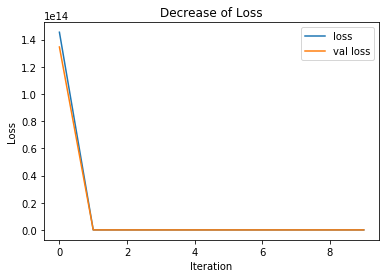

In [7]:
x = np.arange(len(total_loss_0))

plt.title("Decrease of Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(x, total_loss_0, label = 'loss')
plt.plot(x, total_val_loss_0, label = 'val loss')
plt.legend()
plt.show

## 【問題5】MNISTのモデルを作成

In [8]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# print(X_train.shape) # (60000, 28, 28)
# print(X_test.shape) # (10000, 28, 28)
# print(X_train[0].dtype) # uint8
# #print(X_train[0])
# データフレームから条件抽出

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#trainデータを2次元に変換
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_val = X_val.reshape(-1, 784)

#０～１のfloat型に変換(正規化)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_val = X_val.astype(np.float)
X_train /= 255
X_test /= 255
X_val /= 255
print(X_train.shape)
#one-hot-encoding
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

print("y_train_one_hot.shape",y_train_one_hot.shape)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train_one_hot, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.argmax(Y, axis=1), tf.argmax(tf.nn.softmax(logits), axis=1))

# 指標値計算
#y_train_one_hot.shape
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()

#誤差の記録
total_loss_0 = []
total_val_loss_0 = []

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val_one_hot})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    print("test_acc : {:.3f}".format(test_acc))

(48000, 784)
y_train_one_hot.shape (48000, 10)
Epoch 0, loss : 0.7559, val_loss : 1.0966, acc : 0.600, val_acc : 0.660
Epoch 1, loss : 0.7274, val_loss : 0.9384, acc : 0.800, val_acc : 0.720
Epoch 2, loss : 0.4415, val_loss : 0.6229, acc : 0.900, val_acc : 0.793
Epoch 3, loss : 0.5286, val_loss : 0.4100, acc : 0.800, val_acc : 0.893
Epoch 4, loss : 0.3888, val_loss : 0.3927, acc : 0.900, val_acc : 0.906
Epoch 5, loss : 0.4120, val_loss : 0.4090, acc : 0.900, val_acc : 0.912
Epoch 6, loss : 0.5007, val_loss : 0.3357, acc : 0.900, val_acc : 0.917
Epoch 7, loss : 0.5132, val_loss : 0.3662, acc : 0.900, val_acc : 0.912
Epoch 8, loss : 0.5936, val_loss : 0.3012, acc : 0.900, val_acc : 0.928
Epoch 9, loss : 0.0841, val_loss : 0.3859, acc : 1.000, val_acc : 0.919
test_acc : 0.916
